In [1]:
# First we import the module and start up the Matlab interpreter

import os
import numpy as np
from pace_neutrons import Matlab
m = Matlab()

Trying MATLAB version: 2022b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2022b.ctf))
Searching for Matlab 9.13 in /opt/matlab2021b
Searching for Matlab 9.13 in /opt
Trying MATLAB version: 2021b (/mnt/ceph-training/course_materials/pace_env/lib/python3.11/site-packages/pace_neutrons/ctfs/pace_2021b.ctf))
Searching for Matlab 9.11 in /opt/matlab2021b
Found Matlab 9.11 glnxa64 at /opt/matlab2021b
Interface opened
All features have moved to hor_config


!==================================================================!

All features have moved to hor_config

!==================================================================!

!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !

!           R.A. Ewings, A. Buts, M.D. Le, J van Duijn,            !
!                  I. Bustinduy, and T.G. Perring                  !
!                                  

## Background subtraction

We're now going to look at a procedure for background subtraction, and then to look at tools inspect the data to spot artifacts and "spurions".

In general there are a few ways to get an estimate of the background in an INS experiment (which also depends on what is considered "background"):

* The non-sample background can be estimated by measuring the empty cryostat / sample can / furnace etc. This usually suffices especially if the "10% scattering rule" is followed; otherwise there could be multiple scattering from the sample to the sample environment and then to the detector which would not be captured by the "empty" measurement.
* If you are interested in the magnetic scattering, the sample phonon scattering can be estimated by a measurement at high temperature (above the magnetic ordering temperature) or at high Q.
* Again for magnetic scattering, especially from rare earth compounds, you can use a measurement of a "phonon-blank" - a similar material where the magnetic rare earth is substituted for a non-magnetic analogue (e.g. Lu for Yb).

In the next example we will show an example of the second option from the iron dataset (making a cut at high Q to estimate the phonon background and then using it to subtract the phonon from the low Q data).

*** Step 1 of 1; Read data for  3065394 pixels -- processing data...
 ----->  retained    888442 pixels

*** Completed cat_pixels using 


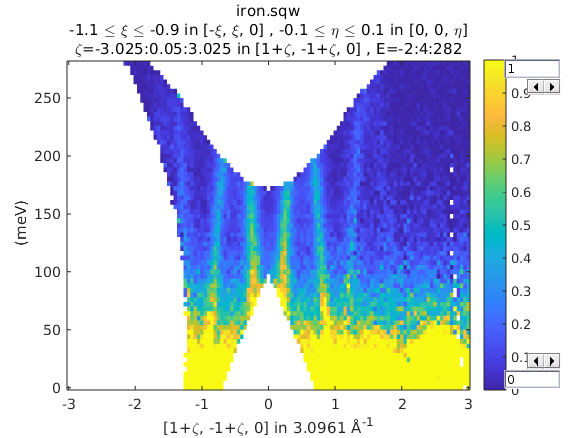

In [2]:
# Make the 2D slice we previously made
%matlab_plot_mode inline

sqw_file = '/mnt/ceph-training/course_materials/sqw_files/iron.sqw'
proj = m.line_proj([1,1,0], [-1,1,0], 'type', 'rrr')

my_slice = m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.1,-0.9], [-0.1,0.1], [0,4,280])
m.plot(my_slice)
m.lz(0, 1)
m.keep_figure()

Which region of this slice would be good region to use as an estimate of the phonon background?

Make a 1D cut of that region, then use the `replicate` function ([documentation here](https://pace-neutrons.github.io/Horace/unstable/manual/Reshaping_etc.html#replicate)) to tile it over the 2D slice, and plot the replicated background. Note that `replicate` requires `dnd` objects as input rather than an `sqw` object - why do you think that is?

Then compute the subtraction and see what the spinwaves would look like.

What would a different region (wider / narrower) look like?

*** Step 1 of 1; Read data for    39934 pixels -- processing data...
 ----->  retained     31874 pixels

*** Completed cat_pixels using 1 pages in 0.006827 sec.



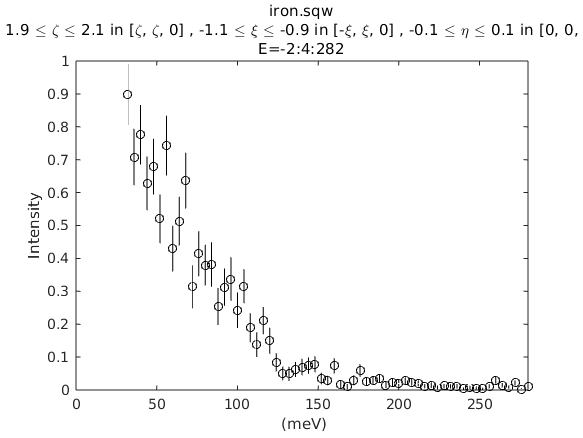

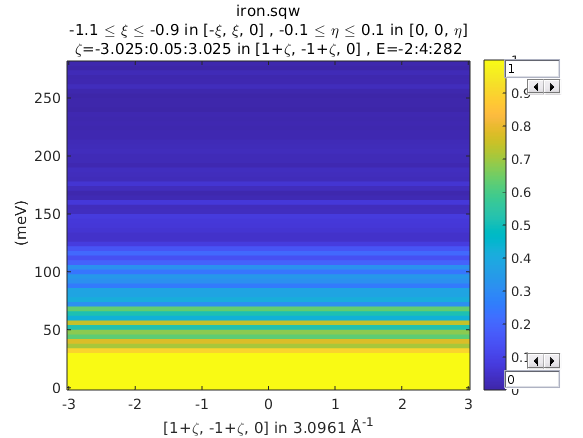

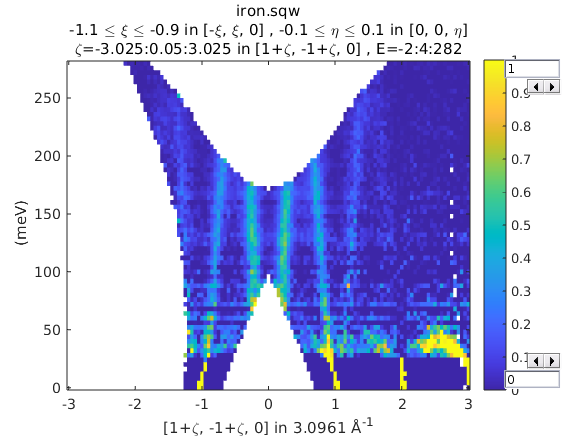

In [4]:
my_bg = m.cut(my_slice, [1.9, 2.1], [])
m.plot(my_bg)
m.ly(0, 1)
m.keep_figure()

my_bg_2d = m.replicate(m.d1d(my_bg), m.d2d(my_slice))
m.plot(my_bg_2d)
m.lz(0, 1)
m.keep_figure()

my_subtracted = m.d2d(my_slice) - my_bg_2d
m.plot(my_subtracted)
m.lz(0, 1)
m.keep_figure()

----

## Investigating spurious data

Some forms of "backgrounds" (non-sample scattering) are actually quite intense and can be mistaken for a signal from the sample - these are usually called "spurions" by instrument scientists and some users. 

The bcc-iron dataset doesn't have a clear spurion so we will look at two different small datasets instead.

* `spurious1` is a 3D sqw object cut from a larger dataset with `u=[1,0,0]` and `v=[0,1,0]` and energy transfer (it was generated by integrating over `w=[0,0,1]` and saved to a file). This is a magnetic system where the excitations are expected to be weak.
* `spurious2` is a 2D sqw object cut from a larger dataset showing the H-K plane integrated over the elastic line. The material here has a cubic structure. 

One of the key tools we will use for this is the `run_inspector` which allows you to decompose a cut into the parts measured at each sample rotation angle (that is each contributing `spe`/`nxspe` file).

But first load the two files using the `sqw` command and plot them and look to see if you can spot what is wrong with them.

In [10]:
%matlab_plot_mode windowed

w_sp1 = m.sqw('/mnt/ceph-training/course_materials/sqw_files/spurious1.sqw')
m.plot(w_sp1)

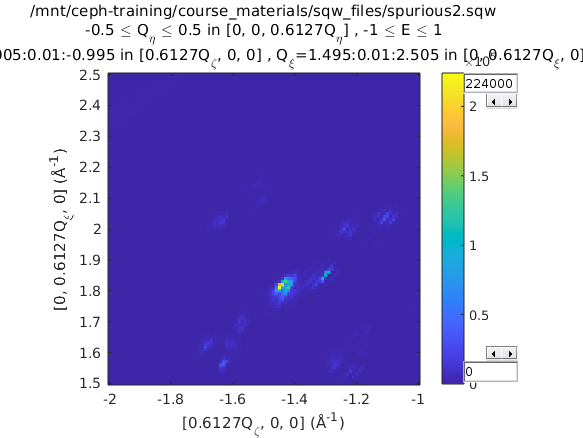

In [9]:
%matlab_plot_mode windowed

w_sp2 = m.sqw('/mnt/ceph-training/course_materials/sqw_files/spurious2.sqw')
m.plot(w_sp2)

Let's concentrate on `spurious1` - make a 2D slice (keeping pixels) of `w_sp1` which contains the spurious scattering and use `run_inspector` on this 2D slice.

*** Step 1 of 1; Read data for   611423 pixels -- processing data...
 ----->  retained    487733 pixels

*** Completed cat_pixels using 1 pages in 0.060501 sec.

*** Step 1 of 1; Read data for   443338 pixels -- processing data...
 ----->  retained    396507 pixels

*** Completed cat_pixels using 1 pages in 0.027951 sec.

*** Step 1 of 1; Read data for   606245 pixels -- processing data...
 ----->  retained    543705 pixels

*** Completed cat_pixels using 1 pages in 0.027021 sec.



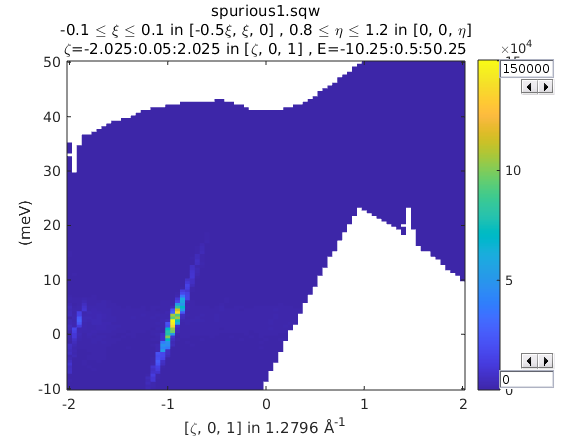

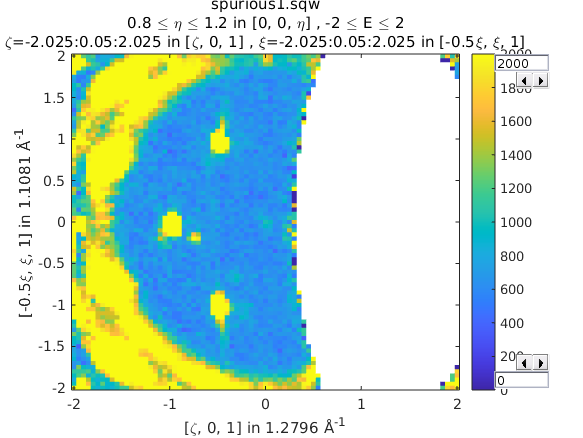

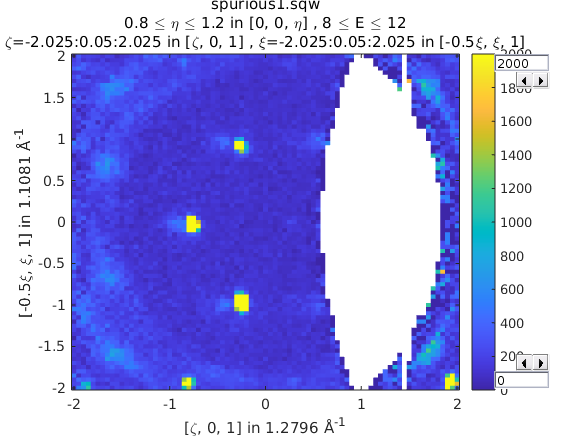

In [11]:
%matlab_plot_mode inline

# =========================================================================
#                            Spurious data
# =========================================================================

cut1_sp1 = m.cut(w_sp1, [], [-0.1, 0.1], []);
m.plot(cut1_sp1); m.keep_figure();
# You should see an intense streak at the Bragg position.
# Lets look at a reciprocal space map of it
m.plot(m.cut(w_sp1, [], [], [-2, 2])); m.lz(0, 2000); m.keep_figure();
m.plot(m.cut(w_sp1, [], [], [8, 12])); m.lz(0, 2000); m.keep_figure();


In [12]:
%matlab_plot_mode windowed

# You should see that there are 3 streaks all in the same direction,
# all coming out of a Bragg peak.
m.run_inspector(cut1_sp1)
# Move through the runs – you should see around run 22 that there is a very
# intense diagonal streak which is present in several runs.

# The excitations are too intense and are not symmetric about the Bragg peak
# so they are not real dispersion, but because they are associated with the
# sample Bragg peak, it suggests they _are_ scattering from the sample.
# In fact they are a detector artefact. This happens because the crystal
# is aligned such that equivalent off-plane Bragg peaks hit a single detector
# tube at the same time causing the electronics to misrecord neutron events,
# because the peaks are so intense.

Let's now turn to the second file - as it is already a 2D sqw file, we can just run `run_inspector` on it directly.

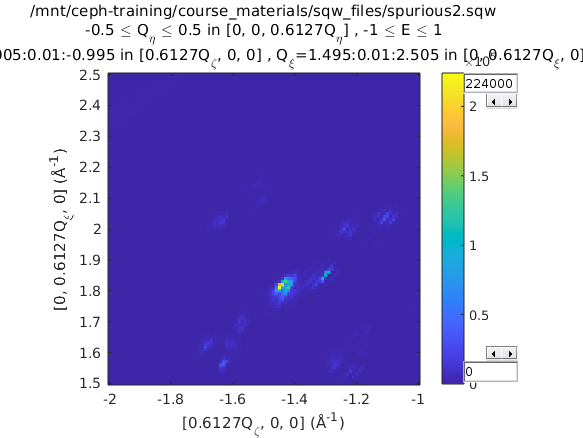

In [13]:
%matlab_plot_mode inline

m.plot(w_sp2)

In [14]:
%matlab_plot_mode windowed

# You should see that there are Bragg peaks but they don’t seem to have the
# 6-fold symmetry you would expect from the (111) plane of a cubic crystal.
m.run_inspector(w_sp2, 'col', [0, 10000])
# Move through the run_inspector. You should see that the sqw file was formed
# of a set of 46 scans from 0 to 90 deg in 2 deg steps, and then another
# 45 scans from 1 to 89 deg in 2 deg steps.
# Comparing runs 22-27 and 69-74 (you can use run_inspector twice to get 2 plots)
# you should see the scattering is similar but doesn't match up
# (e.g. run 22 looks like run 70 but are 5 degrees apart).
# This is because during the rotation from 90 deg to 1 deg for the second set
# of scans, the sample assembly became stuck and the motor lost its position
# So the second set was not actually measuring from 1 to 89 deg.

## Masking data

As you saw above, sometimes you can get spurious scattering which you might want to mask out of the data.

You can use the `mask` or `mask_points` function for this. [Documentation on both are here](https://pace-neutrons.github.io/Horace/unstable/manual/Reshaping_etc.html#mask).

To demonstrate we will use the iron-dataset again and just mask an arbitrary region in our favourite 2D cut - first using the `mask` routine, then using `mask_points`.

*** Step 1 of 1; Read data for  3065394 pixels -- processing data...
 ----->  retained    888442 pixels

*** Completed cat_pixels using 1 pages in 0.033947 sec.



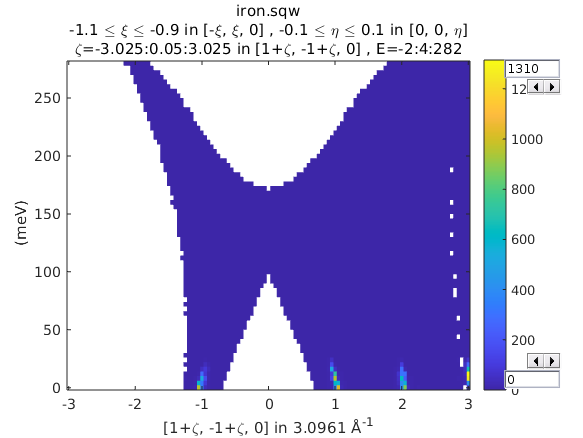

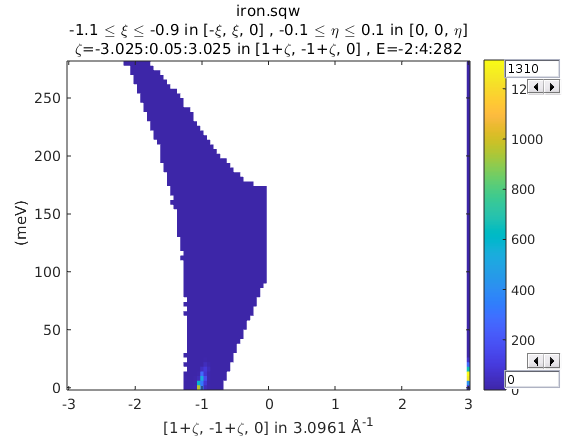

In [20]:
%matlab_plot_mode inline

# Mask parts of a dataset out, e.g. if there is a region with a spurion that
# you wish to remove before proceeding to fitting the data
sqw_file = '/mnt/ceph-training/course_materials/sqw_files/iron.sqw'
proj = m.line_proj([1,1,0], [-1,1,0], 'type', 'rrr')
my_slice = m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-1.1,-0.9], [-0.1,0.1], [0,4,280])

# Define the mask array (keeping everything) `npix` is the internal array of pixels.
# Then set a chunk of it to zero to mask out.
mask_arr = m.ones(m.size(my_slice.data.npix))
# We need to use `copy` here because assignment in Python is not duplication
mask_arr2 = np.copy(mask_arr)
mask_arr2[60:120,:] = 0;   # Remember to use Python 0-based indexing here

my_slice_masked1 = m.mask(my_slice,mask_arr);  # should do nothing
my_slice_masked2 = m.mask(my_slice,mask_arr2);

m.plot(my_slice_masked1); m.keep_figure();
m.plot(my_slice_masked2); m.keep_figure();


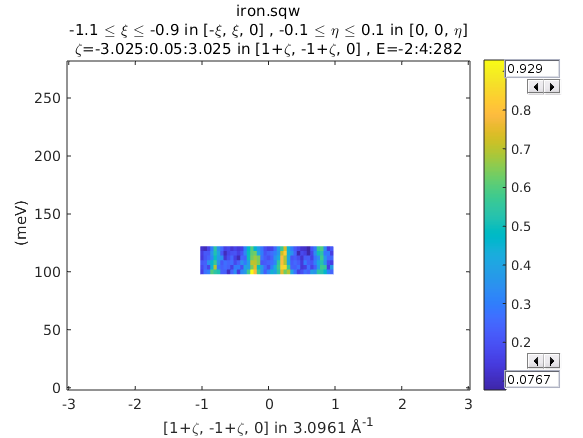

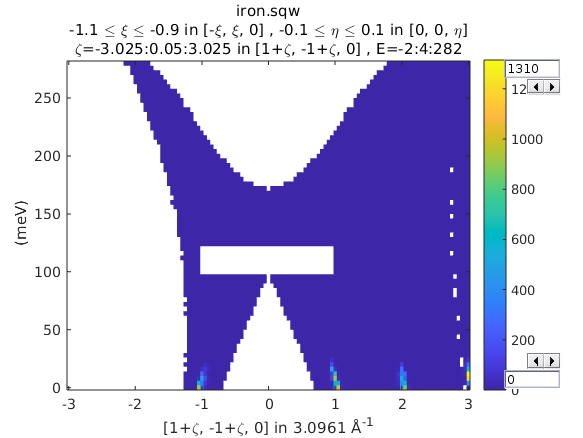

In [21]:
# Mask out specific points, if the mask you need for the above is more complex:
sel1 = m.mask_points(my_slice,   'keep', [-1,1,100,120])  # specify limits to keep
sel2 = m.mask_points(my_slice, 'remove', [-1,1,100,120])  # specify limits to remove

my_slice_masked3 = m.mask(my_slice, sel1)
my_slice_masked4 = m.mask(my_slice, sel2)

m.plot(my_slice_masked3); m.keep_figure();
m.plot(my_slice_masked4); m.keep_figure();

Now, let's try to mask the spurion from the `spurious1.sqw` dataset:

* Make a Q-E cut of the `spurious1.sqw` dataset integrating between -0.6<Qh<-0.5 – you should see a spurious spot around Qk=0 and 18meV. Use either `mask` or `mask_points` to mask this spurious spot.


*** Step 1 of 1; Read data for   452573 pixels -- processing data...
 ----->  retained    304730 pixels

*** Completed cat_pixels using 1 pages in 0.013041 sec.



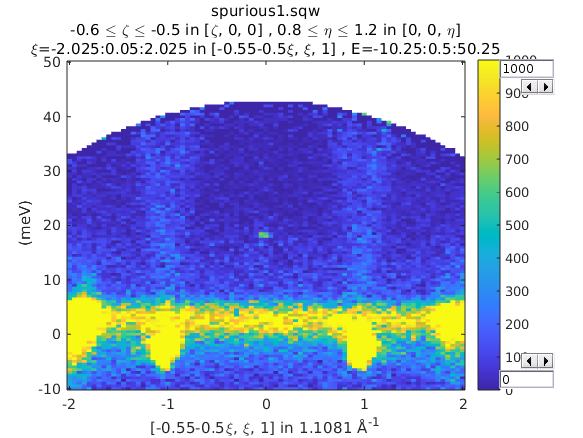

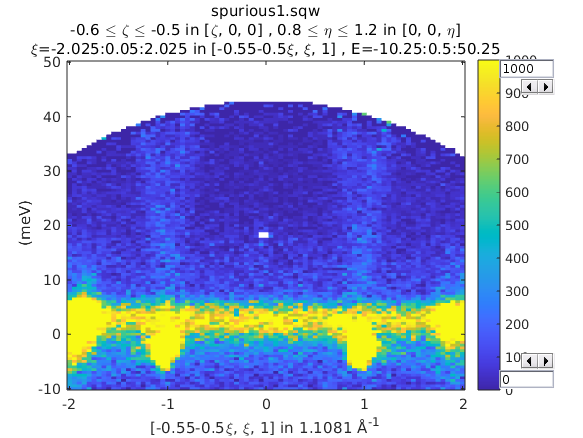

In [22]:
# Masking spurious data
cut_sp1 = m.cut(w_sp1, [-0.6, -0.5], [], [])
m.plot(cut_sp1); m.keep_figure(); m.lz(0, 1000)

# Determine the mask – best way is to plot the actual picture with pcolor
#m.figure(); m.pcolor(cut_sp1.data.s); m.caxis([0,1000])
# Then determine the coordinates from this (remember that pcolor transposes the matrix)
mask_arr_sp = m.ones(m.size(cut_sp1.data.npix))
mask_arr_sp[39:41, 56:58] = 0
wmasked = m.mask(cut_sp1, mask_arr_sp)
m.plot(wmasked)
m.lz(0, 1000)

## Symmetrisation

We'll again use the bcc-iron dataset as an example of how to symmetrise data. We'll just be demonstrating the simplistic mirror-folding operation here. Horace now supports more complex symmetry operations, [described in the documentation here](https://pace-neutrons.github.io/Horace/unstable/manual/Symmetrising_etc.html).


*** Step 1 of 1; Read data for  1156066 pixels -- processing data...
 ----->  retained    704718 pixels

*** Completed cat_pixels using 1 pages in 0.032173 sec.



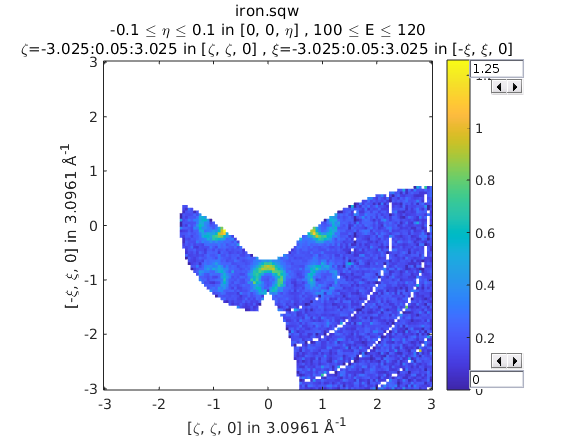

In [24]:
# We first make a reciprocal space map showing rings of magnetic scattering:

my_slice2 = m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-3,0.05,3], [-0.1,0.1], [100,120])
m.plot(my_slice2)

Now, use `symmetrise_sqw` to apply a symmetry operation to this dataset. [Help here](https://pace-neutrons.github.io/Horace/unstable/manual/Symmetrising_etc.html#symmetrise-sqw).

We want to fold along a vertical line centred at *x=0*. Use a `SymopReflection` to define this and then `symmetrise_sqw` to apply it. `SymopReflection` requires two vectors to define the mirror plane - what are these? It also requires another vector to define a point on the plane (an offset - as we want to mirror above *x=0* we can leave the default point `[0,0,0]`

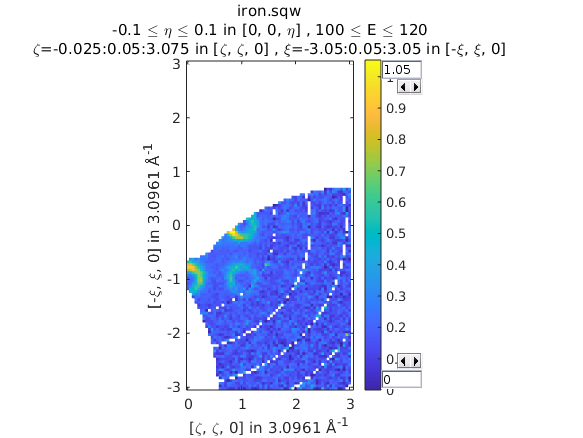

In [28]:
# Fold along vertical:
symop = m.SymopReflection([-1,1,0],[0,0,1])
my_sym = m.symmetrise_sqw(my_slice2, symop)
m.plot(my_sym)

Now work out how to specify two planes that run along the diagonals of the plot axes. Apply these two symmetrisation operations to the data (i.e. fold along one diagonal, then the other). You should have a wedge of data. 

If you find, after plotting, that the wedge is on the negative Q side then try altering the order of the two vectors that define the reflection plane [the reason for this is that the reflection plane is dealt with in the internals of the Horace code by its surface normal, which is determined from the cross product of the two vectors in the plane, and *(a ⨯ b) = -(b ⨯ a)*.


### [Optional extension] 

Let’s try to do some much more complicated origami on the data! Make a volume cut, using the same Q axes and energy integration as before, but make a plot axis going from -2 to 2 in steps of 0.05. Plot this to see where all the rings of magnetic scattering are. See if you can figure out a way of doing multiple reflections that get all of the rings to overlap onto one.


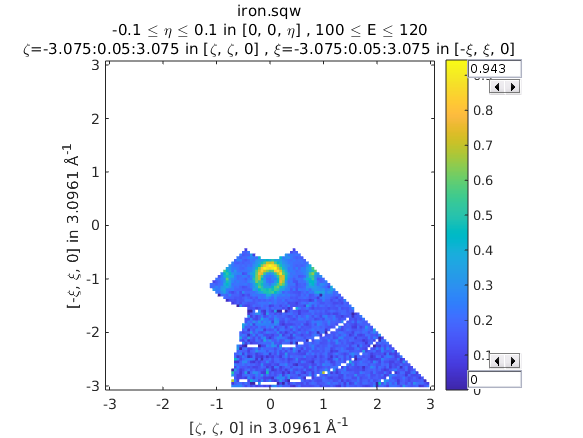

In [56]:
# Two folds along diagonals - first apply one then the other
my_sym2 = m.symmetrise_sqw(my_slice2, m.SymopReflection([1,0,0], [0,0,1]))
my_sym2 = m.symmetrise_sqw(my_sym2, m.SymopReflection([0,1,0], [0,0,1]))
m.plot(my_sym2)


In [59]:
%matlab_plot_mode windowed

# Some origami!
my_slice3 = m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-3,0.05,3], [-2,0.05,2], [100,120]);
m.plot(my_slice3)

*** Step 1 of 1; Read data for  7154218 pixels -- processing data...
 ----->  retained   7080049 pixels

*** Completed cat_pixels using 1 pages in 0.26914 sec.



In [60]:
sym1 = m.symmetrise_sqw(my_slice3, [0,1,0], [1,0,0], [0,0,0]);
m.plot(sym1);

In [ ]:
sym2 = m.symmetrise_sqw(sym1, [1,0,0], [0,0,1], [0,0,0]);
sym2 = m.symmetrise_sqw(sym2, [0,1,0], [0,0,1], [0,0,0]);

# Squeeze out all the dead volume
m.plot(m.compact(sym2))

# You can also perform whole-dataset symmetrisation with gen_sqw()
# when the sqw file is created. (Whole dataset symmetrisation is not
# supported after the sqw if create at the moment).
# First you need to define a symmetrisation function such as:
#
# def wout = my_sym(win):
#    wout = m.symmetrise_sqw(win, [1,0,0], [0,1,0], [0,0,0])
#
# Then you can call gen_sqw with the "transform_sqw" argument, e.g.:
#
# m.gen_sqw(spefile, par_file, sym_sqw_file, efix, emode, alatt, angdeg,
#           u, v, psi, omega, dpsi, gl, gs, 'transform_sqw', my_sym)